## Setup

In [2]:
import os
import sys
import json
import torch
import tqdm
import time
sys.path.append(os.path.abspath('../'))
from UNet import UNet
from ModelWrapper import ModelWrapper
from FlowOT import FlowOT
from dataset import dataset
import matplotlib.pyplot as plt 
from FID_class import FID
from torch.optim.lr_scheduler import PolynomialLR


## Checkpoints

save_checkpoints: True = Checkpoints will be saved, False  = Checkpoints will not be saved

load_for_continuation: True = Start from the last checkpoint, False = Start from scratch 

If false, the model will orverride the existing checkpoints

In [9]:
save_checkpoints = True
load_for_continuation = True
print(os.getcwd())
checkpoint_interval = 10 #<-- How often should we do checkpoints
model_save_path = './checkpoints/'
checkpoint_filename = 'model_checkpoint.pth'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

e:\AI\TDDE70\tdde70_project\structured_code\FlowOT_UNet


## Parameters and imports 

cuda
Seed: 0
Dataset will be downloaded to: e:\AI\TDDE70\tdde70_project\structured_code\datasets
Files already downloaded and verified
torch.Size([128, 3, 32, 32])


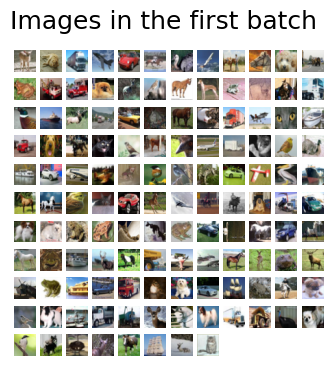

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
num_epochs = 500
img_size = 32 
batch_size = 128
eval_batch_size = 20

# Initialize model
net = UNet().to(device)
model = ModelWrapper(net)
fm = FlowOT()
cifar10 = dataset(batch_size)
dataloader = cifar10.dataloader

# Initialize Optimizer
#The learning rate is double the one in paper since we run half of the numb of epoch so that the decay is not to quick
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = PolynomialLR(optimizer, total_iters=num_epochs, power=2.0) #polynomial decay since power = 2
start_epoch = 0

## Train Loop

In [4]:
training_time_file = "training_time.json"

#Rename the jsonfile that exists if doing a new run
loss_history_file = "loss_history_flow.json"

if load_for_continuation and os.path.exists(model_save_path + checkpoint_filename):
    checkpoint = torch.load(model_save_path + checkpoint_filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    if os.path.exists(loss_history_file):
        with open(loss_history_file, "r") as file:
            loss_history = json.load(file)
    else:
        loss_history = {}
    print(f"Resuming training from epoch {start_epoch}")

# Check if loss history file exists and is not empty, otherwise initialize it
if not os.path.exists(loss_history_file) or os.stat(loss_history_file).st_size == 0:
    with open(loss_history_file, "w") as file:
        json.dump({}, file)

# Start the timer at the beginning of the training session
start_time = time.time()
print("Training model...")
for epoch in range(start_epoch, num_epochs):
    model.train()
    lbar = tqdm.tqdm(cifar10.dataloader)
    lbar.set_description(f"Epoch {epoch}")
    total_loss = 0
    for i, (images, labels) in enumerate(lbar):
        images, labels = images.to(device), labels.to(device)
        t = fm.sample_time(images)
        noise = fm.sample_noise(images)
        pred = model(t[:,0,0,0], fm.psi_t(t, noise, images), labels)
        loss = fm.loss(pred, noise, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    scheduler.step()
    average_loss = total_loss / len(lbar)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Avg loss for epoch {epoch}: {average_loss}, Current LR: {current_lr}")

    # Update the JSON file with the new loss for the current epoch
    with open(loss_history_file, "r") as file:
        loss_history = json.load(file)
    loss_history[epoch] = average_loss
    with open(loss_history_file, "w") as file:
        json.dump(loss_history, file, indent=4)

    #Saving checkpoints according to checkpoint_interval
    if save_checkpoints and (epoch % checkpoint_interval == 0 or epoch == num_epochs-1):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history,
        }
        torch.save(checkpoint, model_save_path + f"Checkpoint_{epoch}.pth")

# Calculate total training time
end_time = time.time()
training_duration = end_time - start_time

# Convert seconds to hour, minutes, and seconds
hours = int(training_duration // 3600)
minutes = int((training_duration % 3600) // 60)
seconds = int(training_duration % 60)

# Save the total training time to a JSON file
with open(training_time_file, "w") as file:
    json.dump({
        "hours": hours,
        "minutes": minutes,
        "seconds": seconds
    }, file, indent=4)

print(f"Training completed in {hours} hours, {minutes} minutes, and {seconds} seconds.")

Training model...


Epoch 0: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 0: 0.2060746140111133, Current LR: 0.000996004


Epoch 1: 100%|██████████| 391/391 [02:15<00:00,  2.88it/s]


Avg loss for epoch 1: 0.12356807167648964, Current LR: 0.0009920159999999999


Epoch 2: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 2: 0.1158528709998521, Current LR: 0.0009880359999999999


Epoch 3: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 3: 0.11140173664102164, Current LR: 0.0009840639999999998


Epoch 4: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 4: 0.1091297230566554, Current LR: 0.0009800999999999996


Epoch 5: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 5: 0.10636958394132917, Current LR: 0.0009761439999999995


Epoch 6: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 6: 0.10427575670849637, Current LR: 0.0009721959999999996


Epoch 7: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 7: 0.1030919228863838, Current LR: 0.0009682559999999997


Epoch 8: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 8: 0.1012049910548093, Current LR: 0.0009643239999999996


Epoch 9: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 9: 0.10007737818962473, Current LR: 0.0009603999999999995


Epoch 10: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 10: 0.09908314173102684, Current LR: 0.0009564839999999994


Epoch 11: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 11: 0.0982435180631745, Current LR: 0.0009525759999999996


Epoch 12: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 12: 0.09857045660924424, Current LR: 0.0009486759999999996


Epoch 13: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 13: 0.0975205220301133, Current LR: 0.0009447839999999997


Epoch 14: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 14: 0.09763729499886407, Current LR: 0.0009408999999999996


Epoch 15: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s]


Avg loss for epoch 15: 0.09724796168944415, Current LR: 0.0009370239999999996


Epoch 16: 100%|██████████| 391/391 [02:14<00:00,  2.90it/s]


Avg loss for epoch 16: 0.09665601917773561, Current LR: 0.0009331559999999995


Epoch 17: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 17: 0.09587269947123345, Current LR: 0.0009292959999999995


Epoch 18: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 18: 0.09573593491788411, Current LR: 0.0009254439999999996


Epoch 19: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 19: 0.09573574068829836, Current LR: 0.0009215999999999995


Epoch 20: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 20: 0.0956610792204547, Current LR: 0.0009177639999999995


Epoch 21: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 21: 0.09451971111623832, Current LR: 0.0009139359999999995


Epoch 22: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 22: 0.09373471767777372, Current LR: 0.0009101159999999996


Epoch 23: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 23: 0.09448644717026244, Current LR: 0.0009063039999999995


Epoch 24: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 24: 0.09366522456907556, Current LR: 0.0009024999999999995


Epoch 25: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 25: 0.09431778755791657, Current LR: 0.0008987039999999995


Epoch 26: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 26: 0.09420778892000618, Current LR: 0.0008949159999999996


Epoch 27: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 27: 0.09341999861742835, Current LR: 0.0008911359999999996


Epoch 28: 100%|██████████| 391/391 [02:15<00:00,  2.88it/s]


Avg loss for epoch 28: 0.0933908624455447, Current LR: 0.0008873639999999996


Epoch 29: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 29: 0.09329584947861064, Current LR: 0.0008835999999999996


Epoch 30: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 30: 0.09279219823343979, Current LR: 0.0008798439999999997


Epoch 31: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 31: 0.09313864817323587, Current LR: 0.0008760959999999996


Epoch 32: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 32: 0.09211791302923046, Current LR: 0.0008723559999999996


Epoch 33: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 33: 0.09182777642593969, Current LR: 0.0008686239999999996


Epoch 34: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 34: 0.09194122155761475, Current LR: 0.0008648999999999995


Epoch 35: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 35: 0.09239253864797485, Current LR: 0.0008611839999999996


Epoch 36: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 36: 0.0926961131832179, Current LR: 0.0008574759999999996


Epoch 37: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s]


Avg loss for epoch 37: 0.09182009179040294, Current LR: 0.0008537759999999996


Epoch 38: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 38: 0.0917358904924539, Current LR: 0.0008500839999999996


Epoch 39: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 39: 0.0910093971454274, Current LR: 0.0008463999999999998


Epoch 40: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 40: 0.09132548833213498, Current LR: 0.0008427239999999998


Epoch 41: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 41: 0.09129531471930502, Current LR: 0.0008390559999999997


Epoch 42: 100%|██████████| 391/391 [02:14<00:00,  2.90it/s]


Avg loss for epoch 42: 0.09193096231773991, Current LR: 0.0008353959999999998


Epoch 43: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 43: 0.09115600012376181, Current LR: 0.0008317439999999998


Epoch 44: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 44: 0.09093067160500284, Current LR: 0.0008280999999999999


Epoch 45: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 45: 0.09077586302214571, Current LR: 0.000824464


Epoch 46: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 46: 0.09148704900842189, Current LR: 0.000820836


Epoch 47: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 47: 0.09125319165189552, Current LR: 0.000817216


Epoch 48: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 48: 0.0910396605272732, Current LR: 0.0008136040000000001


Epoch 49: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 49: 0.09093331564646548, Current LR: 0.0008100000000000002


Epoch 50: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 50: 0.09133498620270464, Current LR: 0.0008064040000000001


Epoch 51: 100%|██████████| 391/391 [02:15<00:00,  2.89it/s]


Avg loss for epoch 51: 0.0914064842797911, Current LR: 0.0008028160000000002


Epoch 52: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 52: 0.0903375204414358, Current LR: 0.0007992360000000003


Epoch 53: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 53: 0.09130488305597964, Current LR: 0.0007956640000000002


Epoch 54: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 54: 0.09019525474904443, Current LR: 0.0007921000000000002


Epoch 55: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 55: 0.09039822344661064, Current LR: 0.0007885440000000003


Epoch 56: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 56: 0.09056883823612462, Current LR: 0.0007849960000000004


Epoch 57: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 57: 0.09055393665571652, Current LR: 0.0007814560000000005


Epoch 58: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 58: 0.08977798580208703, Current LR: 0.0007779240000000005


Epoch 59: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 59: 0.09015325138635953, Current LR: 0.0007744000000000004


Epoch 60: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 60: 0.09014308803221759, Current LR: 0.0007708840000000003


Epoch 61: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 61: 0.08998437450669916, Current LR: 0.0007673760000000004


Epoch 62: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 62: 0.09004015467889473, Current LR: 0.0007638760000000004


Epoch 63: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 63: 0.09000242777797572, Current LR: 0.0007603840000000003


Epoch 64: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 64: 0.08984479351955302, Current LR: 0.0007569000000000003


Epoch 65: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 65: 0.08949754364274042, Current LR: 0.0007534240000000003


Epoch 66: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 66: 0.0901191214771222, Current LR: 0.0007499560000000002


Epoch 67: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 67: 0.08964624804685183, Current LR: 0.0007464960000000002


Epoch 68: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 68: 0.09001166413507193, Current LR: 0.0007430440000000003


Epoch 69: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 69: 0.08983053486136829, Current LR: 0.0007396000000000004


Epoch 70: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 70: 0.08958385031089149, Current LR: 0.0007361640000000003


Epoch 71: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 71: 0.08937480826588239, Current LR: 0.0007327360000000002


Epoch 72: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 72: 0.0888689549454033, Current LR: 0.0007293160000000001


Epoch 73: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 73: 0.09010487853947198, Current LR: 0.0007259040000000001


Epoch 74: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 74: 0.08936017812670344, Current LR: 0.0007225


Epoch 75: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 75: 0.08802270071814432, Current LR: 0.0007191040000000001


Epoch 76: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 76: 0.0892897134889727, Current LR: 0.0007157160000000001


Epoch 77: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 77: 0.08862944865775535, Current LR: 0.0007123360000000002


Epoch 78: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 78: 0.0895571408941008, Current LR: 0.0007089640000000002


Epoch 79: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 79: 0.08922283795407361, Current LR: 0.0007056000000000002


Epoch 80: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 80: 0.08934675904033738, Current LR: 0.0007022440000000002


Epoch 81: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 81: 0.08928618204715612, Current LR: 0.0006988960000000002


Epoch 82: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 82: 0.08941740489295681, Current LR: 0.0006955560000000003


Epoch 83: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 83: 0.08862466942471312, Current LR: 0.0006922240000000003


Epoch 84: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 84: 0.08930232926555302, Current LR: 0.0006889000000000003


Epoch 85: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 85: 0.08924472522552666, Current LR: 0.0006855840000000006


Epoch 86: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 86: 0.08822468111810781, Current LR: 0.0006822760000000005


Epoch 87: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 87: 0.08921544636835528, Current LR: 0.0006789760000000005


Epoch 88: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 88: 0.08948401211167845, Current LR: 0.0006756840000000005


Epoch 89: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 89: 0.08900128148705758, Current LR: 0.0006724000000000005


Epoch 90: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 90: 0.08918276404404579, Current LR: 0.0006691240000000005


Epoch 91: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 91: 0.0891680533395094, Current LR: 0.0006658560000000006


Epoch 92: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 92: 0.08865386163792037, Current LR: 0.0006625960000000006


Epoch 93: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 93: 0.0889032918702611, Current LR: 0.0006593440000000007


Epoch 94: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 94: 0.08844375564619099, Current LR: 0.0006561000000000007


Epoch 95: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 95: 0.08918303155990513, Current LR: 0.0006528640000000007


Epoch 96: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 96: 0.08856270942465423, Current LR: 0.0006496360000000007


Epoch 97: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 97: 0.08894319348323071, Current LR: 0.0006464160000000007


Epoch 98: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 98: 0.08854196247313638, Current LR: 0.0006432040000000006


Epoch 99: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 99: 0.08851150817730848, Current LR: 0.0006400000000000007


Epoch 100: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 100: 0.08874800845104105, Current LR: 0.0006368040000000008


Epoch 101: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 101: 0.08841893551370981, Current LR: 0.0006336160000000007


Epoch 102: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 102: 0.08810418895672044, Current LR: 0.0006304360000000008


Epoch 103: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 103: 0.08815288396976183, Current LR: 0.0006272640000000009


Epoch 104: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 104: 0.08898160877206442, Current LR: 0.0006241000000000009


Epoch 105: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 105: 0.08900664298964278, Current LR: 0.0006209440000000009


Epoch 106: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 106: 0.08785320837479418, Current LR: 0.0006177960000000009


Epoch 107: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 107: 0.08823147926793988, Current LR: 0.0006146560000000009


Epoch 108: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 108: 0.08855952675004139, Current LR: 0.0006115240000000009


Epoch 109: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 109: 0.08868290764062911, Current LR: 0.0006084000000000008


Epoch 110: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 110: 0.08813239203389649, Current LR: 0.0006052840000000007


Epoch 111: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 111: 0.0882791641270718, Current LR: 0.0006021760000000007


Epoch 112: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 112: 0.08855896441223067, Current LR: 0.0005990760000000008


Epoch 113: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 113: 0.08861901035622867, Current LR: 0.0005959840000000008


Epoch 114: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 114: 0.08839596440191463, Current LR: 0.0005929000000000008


Epoch 115: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 115: 0.08848612618339641, Current LR: 0.0005898240000000008


Epoch 116: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 116: 0.08861798286209326, Current LR: 0.0005867560000000009


Epoch 117: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 117: 0.08849389635769607, Current LR: 0.0005836960000000008


Epoch 118: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 118: 0.08765549525199338, Current LR: 0.0005806440000000008


Epoch 119: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 119: 0.08829952858369369, Current LR: 0.0005776000000000008


Epoch 120: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 120: 0.0881523811603751, Current LR: 0.0005745640000000008


Epoch 121: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 121: 0.0888462758353909, Current LR: 0.0005715360000000007


Epoch 122: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 122: 0.08877502313202909, Current LR: 0.0005685160000000007


Epoch 123: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 123: 0.08856482060669023, Current LR: 0.0005655040000000006


Epoch 124: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 124: 0.08852183028026615, Current LR: 0.0005625000000000007


Epoch 125: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 125: 0.0875328687755653, Current LR: 0.0005595040000000006


Epoch 126: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 126: 0.08842026474683182, Current LR: 0.0005565160000000006


Epoch 127: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 127: 0.08800566337450082, Current LR: 0.0005535360000000006


Epoch 128: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 128: 0.08814574783796544, Current LR: 0.0005505640000000006


Epoch 129: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 129: 0.08804548270714557, Current LR: 0.0005476000000000005


Epoch 130: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 130: 0.08756902247972195, Current LR: 0.0005446440000000006


Epoch 131: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 131: 0.08729359015936741, Current LR: 0.0005416960000000006


Epoch 132: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 132: 0.08751440816142066, Current LR: 0.0005387560000000006


Epoch 133: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 133: 0.08694735001725004, Current LR: 0.0005358240000000005


Epoch 134: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 134: 0.0882082674699976, Current LR: 0.0005329000000000005


Epoch 135: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 135: 0.08790770942902626, Current LR: 0.0005299840000000005


Epoch 136: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 136: 0.08778365821484714, Current LR: 0.0005270760000000005


Epoch 137: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 137: 0.08783515070176795, Current LR: 0.0005241760000000004


Epoch 138: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 138: 0.08733205937439828, Current LR: 0.0005212840000000004


Epoch 139: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 139: 0.08798074463139409, Current LR: 0.0005184000000000005


Epoch 140: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 140: 0.08721368026245585, Current LR: 0.0005155240000000005


Epoch 141: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 141: 0.08713165354317107, Current LR: 0.0005126560000000005


Epoch 142: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 142: 0.08801510226924705, Current LR: 0.0005097960000000005


Epoch 143: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 143: 0.08782379292999692, Current LR: 0.0005069440000000005


Epoch 144: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 144: 0.08784729663444601, Current LR: 0.0005041000000000005


Epoch 145: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 145: 0.08750256774065744, Current LR: 0.0005012640000000005


Epoch 146: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 146: 0.08748347418921074, Current LR: 0.0004984360000000004


Epoch 147: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 147: 0.08751791284974579, Current LR: 0.0004956160000000004


Epoch 148: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 148: 0.08723921648910284, Current LR: 0.0004928040000000004


Epoch 149: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 149: 0.0875090270510415, Current LR: 0.0004900000000000005


Epoch 150: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 150: 0.08767042947394768, Current LR: 0.0004872040000000005


Epoch 151: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 151: 0.08774308185748127, Current LR: 0.00048441600000000053


Epoch 152: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 152: 0.08675325612354157, Current LR: 0.0004816360000000005


Epoch 153: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 153: 0.08809110857641606, Current LR: 0.00047886400000000045


Epoch 154: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 154: 0.08699061239466947, Current LR: 0.00047610000000000046


Epoch 155: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 155: 0.08746365840782595, Current LR: 0.00047334400000000043


Epoch 156: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 156: 0.08760937228989418, Current LR: 0.0004705960000000004


Epoch 157: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 157: 0.08755227629943273, Current LR: 0.00046785600000000043


Epoch 158: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 158: 0.0872862981370343, Current LR: 0.00046512400000000046


Epoch 159: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 159: 0.08705138439869942, Current LR: 0.00046240000000000045


Epoch 160: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 160: 0.08705451232774178, Current LR: 0.00045968400000000046


Epoch 161: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 161: 0.08679501190209937, Current LR: 0.00045697600000000043


Epoch 162: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 162: 0.08701806069563722, Current LR: 0.0004542760000000004


Epoch 163: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 163: 0.08700636604710309, Current LR: 0.0004515840000000004


Epoch 164: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 164: 0.08718437549022152, Current LR: 0.00044890000000000045


Epoch 165: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 165: 0.08673065954157154, Current LR: 0.00044622400000000044


Epoch 166: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 166: 0.08779369064075562, Current LR: 0.00044355600000000044


Epoch 167: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 167: 0.08700369797704165, Current LR: 0.0004408960000000004


Epoch 168: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 168: 0.08697346980919314, Current LR: 0.0004382440000000004


Epoch 169: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 169: 0.08729778935232431, Current LR: 0.00043560000000000045


Epoch 170: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 170: 0.0871504739955868, Current LR: 0.0004329640000000004


Epoch 171: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 171: 0.08707140593806191, Current LR: 0.00043033600000000056


Epoch 172: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 172: 0.08674736521051973, Current LR: 0.00042771600000000056


Epoch 173: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 173: 0.0873596869085146, Current LR: 0.00042510400000000053


Epoch 174: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 174: 0.0881758236023776, Current LR: 0.0004225000000000005


Epoch 175: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 175: 0.08663658113659495, Current LR: 0.00041990400000000046


Epoch 176: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 176: 0.08715288996544031, Current LR: 0.0004173160000000004


Epoch 177: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 177: 0.0871131251497037, Current LR: 0.0004147360000000004


Epoch 178: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 178: 0.08753617185994488, Current LR: 0.00041216400000000045


Epoch 179: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 179: 0.08654312393092134, Current LR: 0.00040960000000000047


Epoch 180: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 180: 0.08694365180438132, Current LR: 0.00040704400000000045


Epoch 181: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 181: 0.08771230650070073, Current LR: 0.00040449600000000045


Epoch 182: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 182: 0.08740943822714374, Current LR: 0.00040195600000000046


Epoch 183: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 183: 0.08658438475083208, Current LR: 0.00039942400000000044


Epoch 184: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 184: 0.08743627013071724, Current LR: 0.00039690000000000043


Epoch 185: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 185: 0.08685997843056384, Current LR: 0.00039438400000000044


Epoch 186: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 186: 0.08791284345071335, Current LR: 0.0003918760000000004


Epoch 187: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 187: 0.08657965959642855, Current LR: 0.00038937600000000036


Epoch 188: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 188: 0.08636997946921517, Current LR: 0.00038688400000000037


Epoch 189: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 189: 0.08595987618960382, Current LR: 0.0003844000000000004


Epoch 190: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 190: 0.08743064416110363, Current LR: 0.00038192400000000044


Epoch 191: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 191: 0.0873384873008789, Current LR: 0.00037945600000000045


Epoch 192: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 192: 0.08702713841824886, Current LR: 0.00037699600000000043


Epoch 193: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 193: 0.08674449092515595, Current LR: 0.0003745440000000004


Epoch 194: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 194: 0.08676986335336095, Current LR: 0.0003721000000000004


Epoch 195: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 195: 0.08653445229353503, Current LR: 0.00036966400000000045


Epoch 196: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 196: 0.08668607195167591, Current LR: 0.00036723600000000044


Epoch 197: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 197: 0.08734561872604253, Current LR: 0.0003648160000000004


Epoch 198: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 198: 0.0873426772901774, Current LR: 0.00036240400000000036


Epoch 199: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 199: 0.08695980342452789, Current LR: 0.00036000000000000035


Epoch 200: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 200: 0.08687012271045724, Current LR: 0.00035760400000000035


Epoch 201: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 201: 0.087121943340582, Current LR: 0.0003552160000000004


Epoch 202: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 202: 0.08658190275473363, Current LR: 0.00035283600000000036


Epoch 203: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 203: 0.0866989367986884, Current LR: 0.0003504640000000005


Epoch 204: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 204: 0.08689304142047072, Current LR: 0.0003481000000000005


Epoch 205: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 205: 0.0869773201587255, Current LR: 0.0003457440000000004


Epoch 206: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 206: 0.08686588045276339, Current LR: 0.0003433960000000004


Epoch 207: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 207: 0.08679151455002368, Current LR: 0.0003410560000000004


Epoch 208: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 208: 0.08668746166598157, Current LR: 0.00033872400000000037


Epoch 209: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 209: 0.08711471536275371, Current LR: 0.00033640000000000037


Epoch 210: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 210: 0.08663124326244949, Current LR: 0.0003340840000000004


Epoch 211: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 211: 0.08627581985100456, Current LR: 0.00033177600000000037


Epoch 212: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 212: 0.0865178125555558, Current LR: 0.00032947600000000037


Epoch 213: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 213: 0.0869250674839215, Current LR: 0.0003271840000000004


Epoch 214: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 214: 0.0864748050794577, Current LR: 0.00032490000000000036


Epoch 215: 100%|██████████| 391/391 [02:15<00:00,  2.89it/s]


Avg loss for epoch 215: 0.08650954397361907, Current LR: 0.00032262400000000036


Epoch 216: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 216: 0.08618214387265617, Current LR: 0.0003203560000000004


Epoch 217: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 217: 0.08632443004938038, Current LR: 0.00031809600000000035


Epoch 218: 100%|██████████| 391/391 [02:17<00:00,  2.85it/s]


Avg loss for epoch 218: 0.08688164706272847, Current LR: 0.00031584400000000035


Epoch 219: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 219: 0.08691568499254754, Current LR: 0.00031360000000000036


Epoch 220: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 220: 0.08635125000534764, Current LR: 0.00031136400000000033


Epoch 221: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 221: 0.08628958667559392, Current LR: 0.0003091360000000003


Epoch 222: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 222: 0.0859729875155422, Current LR: 0.0003069160000000003


Epoch 223: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 223: 0.08604385189311889, Current LR: 0.00030470400000000026


Epoch 224: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


Avg loss for epoch 224: 0.08637743506132795, Current LR: 0.00030250000000000025


Epoch 225: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]


Avg loss for epoch 225: 0.0862291583700863, Current LR: 0.00030030400000000026


Epoch 226: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 226: 0.08619355059721891, Current LR: 0.00029811600000000023


Epoch 227: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 227: 0.08613182383272654, Current LR: 0.0002959360000000002


Epoch 228: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 228: 0.0867874140439131, Current LR: 0.00029376400000000023


Epoch 229: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 229: 0.08591000792925316, Current LR: 0.00029160000000000026


Epoch 230: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 230: 0.08604180787111182, Current LR: 0.0002894440000000003


Epoch 231: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 231: 0.08625818821399109, Current LR: 0.00028729600000000025


Epoch 232: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 232: 0.08645010476603228, Current LR: 0.0002851560000000003


Epoch 233: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 233: 0.08606978749756312, Current LR: 0.00028302400000000026


Epoch 234: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 234: 0.08627463265529374, Current LR: 0.00028090000000000027


Epoch 235: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 235: 0.0861045480955897, Current LR: 0.00027878400000000024


Epoch 236: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 236: 0.08542121159832192, Current LR: 0.0002766760000000002


Epoch 237: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 237: 0.08641307010217701, Current LR: 0.0002745760000000002


Epoch 238: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 238: 0.08690704759734366, Current LR: 0.00027248400000000025


Epoch 239: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 239: 0.08670194706191188, Current LR: 0.00027040000000000023


Epoch 240: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 240: 0.08634577116088184, Current LR: 0.00026832400000000023


Epoch 241: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 241: 0.08623549094437943, Current LR: 0.00026625600000000025


Epoch 242: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 242: 0.08594951005009434, Current LR: 0.00026419600000000023


Epoch 243: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 243: 0.08557967723483015, Current LR: 0.00026214400000000023


Epoch 244: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 244: 0.08584751933813095, Current LR: 0.00026010000000000025


Epoch 245: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 245: 0.08615430901803629, Current LR: 0.0002580640000000003


Epoch 246: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 246: 0.08580275684061563, Current LR: 0.0002560360000000003


Epoch 247: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 247: 0.08582825594774597, Current LR: 0.0002540160000000003


Epoch 248: 100%|██████████| 391/391 [02:13<00:00,  2.94it/s]


Avg loss for epoch 248: 0.08635665217171544, Current LR: 0.0002520040000000003


Epoch 249: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 249: 0.08649729367564707, Current LR: 0.0002500000000000003


Epoch 250: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 250: 0.0858770936841855, Current LR: 0.0002480040000000003


Epoch 251: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 251: 0.08640533018752437, Current LR: 0.00024601600000000027


Epoch 252: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 252: 0.0863256644448051, Current LR: 0.00024403600000000026


Epoch 253: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 253: 0.08564911146298089, Current LR: 0.00024206400000000025


Epoch 254: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 254: 0.08611473136240869, Current LR: 0.00024010000000000028


Epoch 255: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 255: 0.08603585040782724, Current LR: 0.00023814400000000025


Epoch 256: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 256: 0.08606744018357124, Current LR: 0.00023619600000000026


Epoch 257: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 257: 0.08616837529498902, Current LR: 0.00023425600000000026


Epoch 258: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 258: 0.08574629733172219, Current LR: 0.00023232400000000028


Epoch 259: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 259: 0.08593796450844811, Current LR: 0.0002304000000000003


Epoch 260: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 260: 0.085722226030229, Current LR: 0.0002284840000000003


Epoch 261: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 261: 0.08601919352017401, Current LR: 0.0002265760000000003


Epoch 262: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 262: 0.08570760829598092, Current LR: 0.0002246760000000003


Epoch 263: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 263: 0.08652325719594955, Current LR: 0.00022278400000000034


Epoch 264: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 264: 0.08620523186900732, Current LR: 0.00022090000000000035


Epoch 265: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 265: 0.08643433571700244, Current LR: 0.00021902400000000033


Epoch 266: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 266: 0.08581246468036072, Current LR: 0.00021715600000000036


Epoch 267: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 267: 0.08623361932423414, Current LR: 0.00021529600000000037


Epoch 268: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 268: 0.08538112926589864, Current LR: 0.00021344400000000038


Epoch 269: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 269: 0.08618206627990889, Current LR: 0.0002116000000000004


Epoch 270: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s]


Avg loss for epoch 270: 0.08600305895442548, Current LR: 0.0002097640000000004


Epoch 271: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 271: 0.08663195000051538, Current LR: 0.0002079360000000004


Epoch 272: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 272: 0.08514299508555771, Current LR: 0.00020611600000000038


Epoch 273: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 273: 0.08557865587646699, Current LR: 0.00020430400000000037


Epoch 274: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 274: 0.08588405757608926, Current LR: 0.00020250000000000037


Epoch 275: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 275: 0.08654692126890583, Current LR: 0.00020070400000000036


Epoch 276: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 276: 0.08561812135417138, Current LR: 0.00019891600000000037


Epoch 277: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 277: 0.08598530545945057, Current LR: 0.00019713600000000037


Epoch 278: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 278: 0.0857799890858438, Current LR: 0.0001953640000000004


Epoch 279: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 279: 0.0855994965223705, Current LR: 0.00019360000000000037


Epoch 280: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 280: 0.08604419006563513, Current LR: 0.00019184400000000037


Epoch 281: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 281: 0.08596529278075299, Current LR: 0.00019009600000000046


Epoch 282: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 282: 0.08533099859648044, Current LR: 0.00018835600000000047


Epoch 283: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 283: 0.08564020657097288, Current LR: 0.00018662400000000047


Epoch 284: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 284: 0.08590992124717864, Current LR: 0.00018490000000000046


Epoch 285: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 285: 0.08603695976307325, Current LR: 0.00018318400000000046


Epoch 286: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 286: 0.08666958179696442, Current LR: 0.00018147600000000043


Epoch 287: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 287: 0.08603137262794368, Current LR: 0.00017977600000000044


Epoch 288: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 288: 0.08587414092953553, Current LR: 0.00017808400000000042


Epoch 289: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 289: 0.08545134151759355, Current LR: 0.00017640000000000038


Epoch 290: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 290: 0.08568940940491683, Current LR: 0.0001747240000000004


Epoch 291: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 291: 0.08584366256699842, Current LR: 0.00017305600000000037


Epoch 292: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 292: 0.0861999179091295, Current LR: 0.00017139600000000036


Epoch 293: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 293: 0.08586393325301388, Current LR: 0.00016974400000000035


Epoch 294: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 294: 0.08571816454915439, Current LR: 0.00016810000000000035


Epoch 295: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 295: 0.08600851013075056, Current LR: 0.00016646400000000034


Epoch 296: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 296: 0.08542664044196038, Current LR: 0.00016483600000000034


Epoch 297: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 297: 0.0863226551152861, Current LR: 0.00016321600000000034


Epoch 298: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 298: 0.08549056196456675, Current LR: 0.00016160400000000033


Epoch 299: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 299: 0.08570125729531583, Current LR: 0.00016000000000000034


Epoch 300: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 300: 0.0857102475927004, Current LR: 0.00015840400000000034


Epoch 301: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 301: 0.08504689484834671, Current LR: 0.00015681600000000032


Epoch 302: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 302: 0.08567284771700955, Current LR: 0.0001552360000000003


Epoch 303: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 303: 0.0855386754702729, Current LR: 0.0001536640000000003


Epoch 304: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 304: 0.08576084522868666, Current LR: 0.0001521000000000003


Epoch 305: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 305: 0.0859696673386542, Current LR: 0.0001505440000000003


Epoch 306: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 306: 0.08548249231884851, Current LR: 0.0001489960000000003


Epoch 307: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 307: 0.08533227655207715, Current LR: 0.0001474560000000003


Epoch 308: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 308: 0.08558354610601045, Current LR: 0.0001459240000000003


Epoch 309: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 309: 0.08563854977907732, Current LR: 0.0001444000000000003


Epoch 310: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 310: 0.08598370524242406, Current LR: 0.0001428840000000003


Epoch 311: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 311: 0.0853546271886667, Current LR: 0.00014137600000000027


Epoch 312: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 312: 0.08564182873958212, Current LR: 0.00013987600000000026


Epoch 313: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 313: 0.08581298117137626, Current LR: 0.00013838400000000024


Epoch 314: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 314: 0.08606376904813225, Current LR: 0.00013690000000000024


Epoch 315: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 315: 0.08582441701227442, Current LR: 0.0001354240000000002


Epoch 316: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 316: 0.08494115927640129, Current LR: 0.0001339560000000002


Epoch 317: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 317: 0.08615010269843709, Current LR: 0.0001324960000000002


Epoch 318: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 318: 0.08538410799277713, Current LR: 0.00013104400000000022


Epoch 319: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 319: 0.08572923980862893, Current LR: 0.00012960000000000022


Epoch 320: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 320: 0.085689002481263, Current LR: 0.00012816400000000022


Epoch 321: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 321: 0.08565312564906562, Current LR: 0.0001267360000000002


Epoch 322: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 322: 0.08572850023846493, Current LR: 0.00012531600000000018


Epoch 323: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 323: 0.08549406581446338, Current LR: 0.00012390400000000017


Epoch 324: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 324: 0.08632704994791304, Current LR: 0.00012250000000000016


Epoch 325: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 325: 0.08564497740067484, Current LR: 0.00012110400000000016


Epoch 326: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 326: 0.08576391509655491, Current LR: 0.00011971600000000014


Epoch 327: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 327: 0.08615166781579747, Current LR: 0.00011833600000000012


Epoch 328: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 328: 0.08544767451713152, Current LR: 0.00011696400000000011


Epoch 329: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 329: 0.08498111245272409, Current LR: 0.00011560000000000009


Epoch 330: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 330: 0.08623441929936104, Current LR: 0.0001142440000000001


Epoch 331: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 331: 0.0852466118343346, Current LR: 0.00011289600000000008


Epoch 332: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 332: 0.08514873431924054, Current LR: 0.00011155600000000008


Epoch 333: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 333: 0.08477657791370016, Current LR: 0.00011022400000000007


Epoch 334: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 334: 0.08567008305617306, Current LR: 0.00010890000000000009


Epoch 335: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 335: 0.08529859026679602, Current LR: 0.00010758400000000009


Epoch 336: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 336: 0.08593859773157808, Current LR: 0.00010627600000000009


Epoch 337: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 337: 0.08543039827852908, Current LR: 0.0001049760000000001


Epoch 338: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 338: 0.08567526989885609, Current LR: 0.0001036840000000001


Epoch 339: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 339: 0.08557143980813453, Current LR: 0.00010240000000000009


Epoch 340: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 340: 0.08602273319383412, Current LR: 0.00010112400000000008


Epoch 341: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 341: 0.08592542977360508, Current LR: 9.985600000000008e-05


Epoch 342: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 342: 0.0850885376486632, Current LR: 9.859600000000007e-05


Epoch 343: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 343: 0.08525681295586973, Current LR: 9.734400000000014e-05


Epoch 344: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 344: 0.08572710701800368, Current LR: 9.610000000000015e-05


Epoch 345: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 345: 0.0853550679733991, Current LR: 9.486400000000015e-05


Epoch 346: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 346: 0.08574188771226522, Current LR: 9.363600000000015e-05


Epoch 347: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 347: 0.0853244244595013, Current LR: 9.241600000000015e-05


Epoch 348: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 348: 0.08577748170822783, Current LR: 9.120400000000015e-05


Epoch 349: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 349: 0.08485727078850618, Current LR: 9.000000000000014e-05


Epoch 350: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 350: 0.0856016048651827, Current LR: 8.880400000000013e-05


Epoch 351: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 351: 0.08518354002090976, Current LR: 8.761600000000013e-05


Epoch 352: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 352: 0.08506520717497677, Current LR: 8.643600000000012e-05


Epoch 353: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 353: 0.08547217505590995, Current LR: 8.526400000000011e-05


Epoch 354: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 354: 0.08616598104805592, Current LR: 8.41000000000001e-05


Epoch 355: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 355: 0.08521829164394028, Current LR: 8.29440000000001e-05


Epoch 356: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 356: 0.08545642671987529, Current LR: 8.179600000000011e-05


Epoch 357: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 357: 0.08553393981645784, Current LR: 8.06560000000001e-05


Epoch 358: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 358: 0.08499357437767337, Current LR: 7.95240000000001e-05


Epoch 359: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 359: 0.08511560204465066, Current LR: 7.84000000000001e-05


Epoch 360: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 360: 0.08567833454560136, Current LR: 7.728400000000011e-05


Epoch 361: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 361: 0.08513980524619218, Current LR: 7.617600000000012e-05


Epoch 362: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 362: 0.08555628521286923, Current LR: 7.507600000000012e-05


Epoch 363: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 363: 0.08517730316085279, Current LR: 7.398400000000011e-05


Epoch 364: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 364: 0.08529246758545755, Current LR: 7.29000000000001e-05


Epoch 365: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 365: 0.08587357851550402, Current LR: 7.18240000000001e-05


Epoch 366: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 366: 0.08550153085795205, Current LR: 7.07560000000001e-05


Epoch 367: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 367: 0.08578288762846871, Current LR: 6.96960000000001e-05


Epoch 368: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 368: 0.08557671058894423, Current LR: 6.86440000000001e-05


Epoch 369: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 369: 0.08516063112432085, Current LR: 6.76000000000001e-05


Epoch 370: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 370: 0.08601981593900934, Current LR: 6.65640000000001e-05


Epoch 371: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 371: 0.08497577488346172, Current LR: 6.55360000000001e-05


Epoch 372: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 372: 0.08484598195842465, Current LR: 6.45160000000001e-05


Epoch 373: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 373: 0.08561599273663348, Current LR: 6.35040000000001e-05


Epoch 374: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 374: 0.08481714941199174, Current LR: 6.250000000000011e-05


Epoch 375: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 375: 0.08514291347216463, Current LR: 6.150400000000011e-05


Epoch 376: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 376: 0.08540648675483206, Current LR: 6.051600000000011e-05


Epoch 377: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 377: 0.08559204407436463, Current LR: 5.95360000000001e-05


Epoch 378: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 378: 0.08508512634984063, Current LR: 5.85640000000001e-05


Epoch 379: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 379: 0.08561002259211772, Current LR: 5.76000000000001e-05


Epoch 380: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 380: 0.0850960028636486, Current LR: 5.6644000000000103e-05


Epoch 381: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 381: 0.08505325434762803, Current LR: 5.5696000000000105e-05


Epoch 382: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 382: 0.08508053660164099, Current LR: 5.4756000000000104e-05


Epoch 383: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 383: 0.08526771203102664, Current LR: 5.382400000000011e-05


Epoch 384: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 384: 0.08546809425286929, Current LR: 5.290000000000011e-05


Epoch 385: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 385: 0.08481484146602929, Current LR: 5.19840000000001e-05


Epoch 386: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 386: 0.08544187062917769, Current LR: 5.10760000000001e-05


Epoch 387: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 387: 0.08472495798564628, Current LR: 5.01760000000001e-05


Epoch 388: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 388: 0.08508049641423823, Current LR: 4.92840000000001e-05


Epoch 389: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 389: 0.08498338141176097, Current LR: 4.84000000000001e-05


Epoch 390: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 390: 0.08522591869468274, Current LR: 4.752400000000009e-05


Epoch 391: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 391: 0.08529272444946381, Current LR: 4.665600000000008e-05


Epoch 392: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 392: 0.0848874456589789, Current LR: 4.5796000000000074e-05


Epoch 393: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 393: 0.08487673997497924, Current LR: 4.494400000000007e-05


Epoch 394: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 394: 0.08544040252180661, Current LR: 4.410000000000007e-05


Epoch 395: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 395: 0.08498507299843956, Current LR: 4.326400000000007e-05


Epoch 396: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 396: 0.08497859045977482, Current LR: 4.243600000000007e-05


Epoch 397: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 397: 0.08456177784658758, Current LR: 4.161600000000007e-05


Epoch 398: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 398: 0.08521527312981808, Current LR: 4.080400000000007e-05


Epoch 399: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 399: 0.08541704841968044, Current LR: 4.000000000000007e-05


Epoch 400: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 400: 0.08514991354988054, Current LR: 3.920400000000007e-05


Epoch 401: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 401: 0.08494032829847482, Current LR: 3.841600000000006e-05


Epoch 402: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 402: 0.08505764293015156, Current LR: 3.763600000000006e-05


Epoch 403: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 403: 0.08564802282073004, Current LR: 3.686400000000006e-05


Epoch 404: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 404: 0.08457884299175819, Current LR: 3.610000000000006e-05


Epoch 405: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 405: 0.08604014119909853, Current LR: 3.534400000000005e-05


Epoch 406: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 406: 0.0842617391549108, Current LR: 3.4596000000000094e-05


Epoch 407: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 407: 0.08526900296321001, Current LR: 3.385600000000009e-05


Epoch 408: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 408: 0.08562185758215082, Current LR: 3.3124000000000085e-05


Epoch 409: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 409: 0.08488084800789118, Current LR: 3.240000000000008e-05


Epoch 410: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 410: 0.0852745994544395, Current LR: 3.1684000000000085e-05


Epoch 411: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 411: 0.08472177519670228, Current LR: 3.097600000000008e-05


Epoch 412: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 412: 0.08510291465865377, Current LR: 3.0276000000000077e-05


Epoch 413: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 413: 0.08544766691410938, Current LR: 2.9584000000000075e-05


Epoch 414: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 414: 0.08495641474986015, Current LR: 2.8900000000000072e-05


Epoch 415: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 415: 0.08512262818987107, Current LR: 2.8224000000000074e-05


Epoch 416: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 416: 0.08510101275980625, Current LR: 2.7556000000000073e-05


Epoch 417: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 417: 0.08499887665671765, Current LR: 2.689600000000007e-05


Epoch 418: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 418: 0.0851239315841509, Current LR: 2.6244000000000066e-05


Epoch 419: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 419: 0.08523676414852557, Current LR: 2.5600000000000063e-05


Epoch 420: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 420: 0.08565052091846685, Current LR: 2.4964000000000065e-05


Epoch 421: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 421: 0.0842618396138901, Current LR: 2.4336000000000067e-05


Epoch 422: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 422: 0.08517637824082314, Current LR: 2.3716000000000066e-05


Epoch 423: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 423: 0.08528309132513183, Current LR: 2.3104000000000065e-05


Epoch 424: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 424: 0.0843513318339882, Current LR: 2.2500000000000062e-05


Epoch 425: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 425: 0.08511878355689671, Current LR: 2.1904000000000063e-05


Epoch 426: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 426: 0.08469688705623607, Current LR: 2.1316000000000065e-05


Epoch 427: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 427: 0.08504094311114772, Current LR: 2.073600000000006e-05


Epoch 428: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 428: 0.0854966609031343, Current LR: 2.0164000000000056e-05


Epoch 429: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 429: 0.08561478846746942, Current LR: 1.9600000000000056e-05


Epoch 430: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 430: 0.08514834547896519, Current LR: 1.9044000000000053e-05


Epoch 431: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 431: 0.0848653041150259, Current LR: 1.8496000000000048e-05


Epoch 432: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 432: 0.08616134127997377, Current LR: 1.7956000000000046e-05


Epoch 433: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 433: 0.08579280454179515, Current LR: 1.7424000000000042e-05


Epoch 434: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 434: 0.08489214184948855, Current LR: 1.690000000000004e-05


Epoch 435: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 435: 0.08504231053087717, Current LR: 1.6384000000000038e-05


Epoch 436: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 436: 0.08508657570690145, Current LR: 1.5876000000000036e-05


Epoch 437: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 437: 0.08452254939643318, Current LR: 1.5376000000000034e-05


Epoch 438: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 438: 0.08557032450766819, Current LR: 1.4884000000000034e-05


Epoch 439: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 439: 0.08501404641991686, Current LR: 1.4400000000000033e-05


Epoch 440: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 440: 0.08516494556308707, Current LR: 1.3924000000000031e-05


Epoch 441: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 441: 0.08504417593902944, Current LR: 1.3456000000000028e-05


Epoch 442: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 442: 0.08507774221470289, Current LR: 1.2996000000000026e-05


Epoch 443: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 443: 0.08525420020303458, Current LR: 1.2544000000000024e-05


Epoch 444: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 444: 0.08481209904260342, Current LR: 1.2100000000000023e-05


Epoch 445: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 445: 0.08495965632407562, Current LR: 1.1664000000000022e-05


Epoch 446: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 446: 0.08573703479279032, Current LR: 1.1236000000000023e-05


Epoch 447: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 447: 0.08525005970007318, Current LR: 1.0816000000000021e-05


Epoch 448: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 448: 0.08492386421126782, Current LR: 1.040400000000002e-05


Epoch 449: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 449: 0.08458917203080624, Current LR: 1.0000000000000018e-05


Epoch 450: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 450: 0.08558045093284543, Current LR: 9.604000000000017e-06


Epoch 451: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 451: 0.08481039183066628, Current LR: 9.216000000000016e-06


Epoch 452: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 452: 0.08535791300904111, Current LR: 8.836000000000015e-06


Epoch 453: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 453: 0.0851495859529966, Current LR: 8.464000000000014e-06


Epoch 454: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 454: 0.08473208893443007, Current LR: 8.100000000000014e-06


Epoch 455: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 455: 0.08535719098871017, Current LR: 7.744000000000013e-06


Epoch 456: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 456: 0.08417057956728484, Current LR: 7.396000000000012e-06


Epoch 457: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 457: 0.08522469136873474, Current LR: 7.056000000000011e-06


Epoch 458: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 458: 0.08511022196325195, Current LR: 6.72400000000001e-06


Epoch 459: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 459: 0.08556288297828811, Current LR: 6.400000000000009e-06


Epoch 460: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 460: 0.08543053095984032, Current LR: 6.084000000000008e-06


Epoch 461: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 461: 0.08508893643574947, Current LR: 5.776000000000008e-06


Epoch 462: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 462: 0.0849186767778738, Current LR: 5.4760000000000065e-06


Epoch 463: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 463: 0.08481270032922936, Current LR: 5.184000000000006e-06


Epoch 464: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 464: 0.08447534343242036, Current LR: 4.900000000000005e-06


Epoch 465: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 465: 0.08477481746155283, Current LR: 4.624000000000004e-06


Epoch 466: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 466: 0.08523684781987953, Current LR: 4.356000000000004e-06


Epoch 467: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 467: 0.08492944404825835, Current LR: 4.096000000000003e-06


Epoch 468: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 468: 0.0850917555944389, Current LR: 3.844000000000016e-06


Epoch 469: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 469: 0.08490269051869508, Current LR: 3.6000000000000155e-06


Epoch 470: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 470: 0.08504842313201837, Current LR: 3.3640000000000143e-06


Epoch 471: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 471: 0.08458105019291344, Current LR: 3.1360000000000137e-06


Epoch 472: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 472: 0.08510167835770971, Current LR: 2.916000000000013e-06


Epoch 473: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 473: 0.0853447671360372, Current LR: 2.7040000000000113e-06


Epoch 474: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 474: 0.08497241358546649, Current LR: 2.5000000000000104e-06


Epoch 475: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 475: 0.08518604358748706, Current LR: 2.3040000000000096e-06


Epoch 476: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 476: 0.08444332674412472, Current LR: 2.116000000000009e-06


Epoch 477: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 477: 0.08533241258710242, Current LR: 1.9360000000000082e-06


Epoch 478: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 478: 0.08532129835975749, Current LR: 1.7640000000000078e-06


Epoch 479: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 479: 0.08523980501438956, Current LR: 1.600000000000007e-06


Epoch 480: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 480: 0.08493794403646303, Current LR: 1.4440000000000062e-06


Epoch 481: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 481: 0.08519041673530398, Current LR: 1.2960000000000055e-06


Epoch 482: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 482: 0.0859119043020946, Current LR: 1.156000000000005e-06


Epoch 483: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 483: 0.08509892631141121, Current LR: 1.0240000000000043e-06


Epoch 484: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 484: 0.08508609963195099, Current LR: 9.000000000000038e-07


Epoch 485: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 485: 0.08471784238582072, Current LR: 7.840000000000033e-07


Epoch 486: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 486: 0.08540897782120253, Current LR: 6.760000000000028e-07


Epoch 487: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 487: 0.08525653551225468, Current LR: 5.760000000000025e-07


Epoch 488: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 488: 0.0846977862898651, Current LR: 4.840000000000021e-07


Epoch 489: 100%|██████████| 391/391 [02:12<00:00,  2.94it/s]


Avg loss for epoch 489: 0.08495781850784331, Current LR: 4.000000000000017e-07


Epoch 490: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 490: 0.08454750323920604, Current LR: 3.2400000000000137e-07


Epoch 491: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 491: 0.0846636866212196, Current LR: 2.560000000000011e-07


Epoch 492: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 492: 0.08534168004227416, Current LR: 1.9600000000000083e-07


Epoch 493: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 493: 0.08492168227729895, Current LR: 1.440000000000006e-07


Epoch 494: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 494: 0.08536014911692466, Current LR: 1.0000000000000043e-07


Epoch 495: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 495: 0.0853286262058541, Current LR: 6.40000000000003e-08


Epoch 496: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 496: 0.08493691642799646, Current LR: 3.6000000000000164e-08


Epoch 497: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 497: 0.08429203481625414, Current LR: 1.600000000000007e-08


Epoch 498: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 498: 0.08450088333671965, Current LR: 4.000000000000018e-09


Epoch 499: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]


Avg loss for epoch 499: 0.08508505003379128, Current LR: 0.0
Training completed in 18 hours, 31 minutes, and 14 seconds.


## Display images from checkpoint

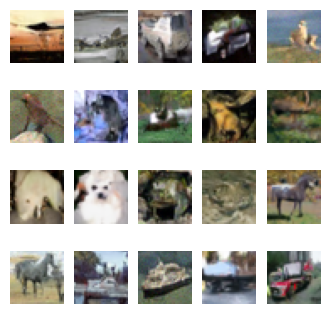

In [ ]:
 # NOTE: Change this to the actual checkpoint path
 
checkpoint_path = "./checkpoints/Checkpoint_499.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Number of images to show:
image_batch_size = 20

model.eval()
labels = torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]).to(device)
with torch.no_grad():
    sample = torch.randn((image_batch_size, 3, img_size, img_size)).to(device)
    output = model.decode(sample, labels).clamp(0,1)
    cifar10.show_images(output)


## Calculate evaluation metrics for checkpoint:

In [7]:
import gc

def load_model_definition():
    net = UNet().to(device)  
    model = ModelWrapper(net)  
    model.eval()
    return model.to(device)

def load_fid_scores():
    try:
        with open("fid_flow.json", "r") as file:
            return json.load(file)
    except FileNotFoundError:
        return {}  # Return an empty dictionary if the file does not exist

# Initialize device and FID calculator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fid = FID()

# Load existing FID scores
fid_scores = load_fid_scores()

# Loop over checkpoints
for epoch in [50, 150, 250, 350, 450]:
    model = load_model_definition()
    checkpoint_path = f"./checkpoints/Checkpoint_{epoch}.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Calculate FID
    fid_score = fid.calculate_FID(model, 1500, 32, device)
    fid_scores[epoch] = fid_score
    print(f"FID for Checkpoint {epoch}: {fid_score}")

    # Write FID scores to JSON
    with open("fid_flow.json", "w") as file:
        json.dump(fid_scores, file, indent=4)

    # Clear memory
    del model
    torch.cuda.empty_cache()
    gc.collect()



Files already downloaded and verified
Saving real images...
Real images Saved, beginning Evaluation...


100%|██████████| 1/1 [01:42<00:00, 102.79s/it]


FID for Checkpoint 50: 76.95209336172894
Saving real images...
Real images Saved, beginning Evaluation...


100%|██████████| 1/1 [01:55<00:00, 115.69s/it]


FID for Checkpoint 150: 55.33233653164655
Saving real images...
Real images Saved, beginning Evaluation...


100%|██████████| 1/1 [01:37<00:00, 97.58s/it]


FID for Checkpoint 250: 52.01054775262975
Saving real images...
Real images Saved, beginning Evaluation...


100%|██████████| 1/1 [01:37<00:00, 97.48s/it]


FID for Checkpoint 350: 51.76117817416605
Saving real images...
Real images Saved, beginning Evaluation...


100%|██████████| 1/1 [01:36<00:00, 96.52s/it]


FID for Checkpoint 450: 48.59135838609876


False
./checkpoints/model_checkpoint.pth


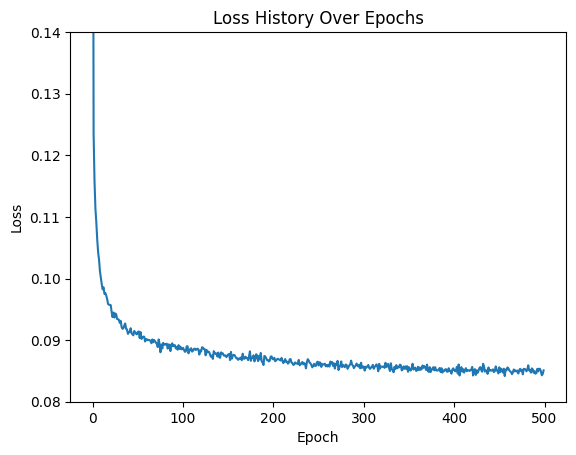

In [8]:
import json
import matplotlib.pyplot as plt

# Assuming model_save_path and checkpoint_filename are defined somewhere above
print(load_for_continuation and os.path.exists(model_save_path + checkpoint_filename))
print(model_save_path + checkpoint_filename)

# Load loss history from JSON file
with open('loss_history_flow.json', 'r') as file:
    loss_history = json.load(file)

# We'll use all epochs for plotting
epochs = sorted(int(epoch) for epoch in loss_history.keys())
loss_values = [loss_history[str(epoch)] for epoch in epochs]  # Convert epoch back to string to access dictionary

# Plotting the loss history
plt.plot(epochs, loss_values)
plt.title("Loss History Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Set the Y-axis limits
y_min, y_max = 0.08, 0.14  # Adjust these values based on desired Y-axis range
plt.ylim(y_min, y_max)


plt.savefig('loss_history_flow.png', dpi=300)  # dpi specifies the resolution. Higher dpi means better quality.

plt.show()

plt.close()  



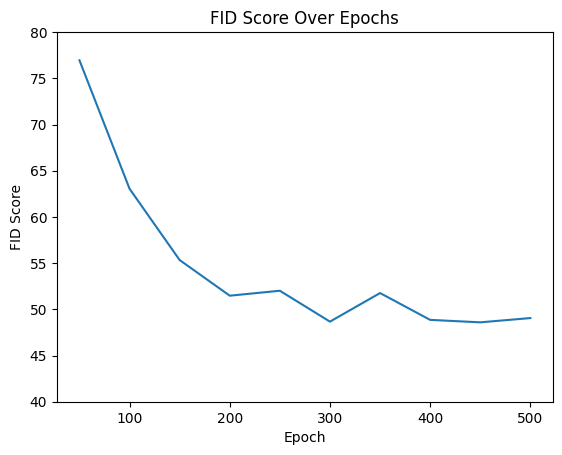

In [10]:
#Plot FID
with open('fid_flow.json', 'r') as file:
    fid_flow_history = json.load(file)

# Load FID scores from 'fid_ddpm.json' in the DDPM folder
with open('fid_ddpm.json', 'r') as file:
    fid_ddpm_history = json.load(file)

# Get epochs and scores for 'fid_flow'
epochs_flow = sorted(int(epoch) for epoch in fid_flow_history.keys())
fid_flow_scores = [fid_flow_history[str(epoch)] for epoch in epochs_flow]

# Get epochs and scores for 'fid_ddpm'
epochs_ddpm = sorted(int(epoch) for epoch in fid_ddpm_history.keys())
fid_ddpm_scores = [fid_ddpm_history[str(epoch)] for epoch in epochs_ddpm]

# Plotting both FID histories
plt.figure(figsize=(10, 5))
plt.plot(epochs_flow, fid_flow_scores, label='FID Flow', marker='o')
plt.plot(epochs_ddpm, fid_ddpm_scores, label='FID DDPM', marker='x')

plt.title("FID Score Comparison Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.grid(True)

# Set the Y-axis limits
y_min, y_max = 40, 80  # Adjust these values based on desired Y-axis range
plt.ylim(y_min, y_max)

plt.savefig('fid_comparison.png', dpi=300)
plt.show()
plt.close()